# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。   
その解析結果をもとに、確実に利益の最小値がプラスになるスキームを構築する。

# 前回までのまとめ
cross pointの直後で注文し、EMA二本の差の極大・極小点のうち最も近い位置の次の点で約定をした場合、特定のポイントの組 (N1, N2) に対してプラスの利益が出ることが分かった。   
しかしながら、対象としたデータは次の観点で不完全であった。

+ 一つはticker data から作成したOHLC
+ 一つはCryptoCompareから取得したOHLCVで、bitflyerの実際のデータと異なっていた

今回は約定履歴から作製したOHLCVデータを用いて、同じ結果が得られるかどうか検討する。

## このノートで調査する内容
* N1, N2を変え、最も利益の出る組み合わせを探す。

## モジュールと関数の用意

In [1]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle

%matplotlib inline

In [2]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2=None):
    """find_cross_points(y1, y2=None) -> numpy.1darray
    find cross points between two data sequences
    If y2 == None, then find the root of y1.
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if y2 is None:
        y2 = np.zeros_like(y1)
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

In [3]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["close"] - dataFrame["open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [4]:
def peakdet(v, delta, x=None):
    """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
        Returns two np.arrays
        function [maxtab, mintab]=peakdet(v, delta, x)
        % PEAKDET Detect peaks in a vector
        % [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        % maxima and minima ("peaks") in the vector V.
        % MAXTAB and MINTAB consists of two columns. Column 1
        % contains indices in V, and column 2 the found values.
        %
        % With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        % in MAXTAB and MINTAB are replaced with the corresponding
        % X-values.
        %
        % A point is considered a maximum peak if it has the maximal
        % value, and was preceded (to the left) by a value lower by
        % DELTA.
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
        v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

## メイン関数

In [5]:
def main(df, N1, N2, N_dec=5):
    """main(df, N1, N2, N_dec=5) -> dict
    calculate some factors
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])

            # minimum index
            index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (mintab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = max(open_[tm+1], close_[tm+1])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            # maximum index
            index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = min(open_[tm+1], close_[tm+1])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]
    
    # calculate benefits
    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[::2]):
        v = benefits[::2][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[1::2]):
        v = benefits[1::2][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

In [6]:
def main_peak(df, N1, N2, N_dec=5):
    """main_peak(df, N1, N2, N_dec=5) -> dict
    calculate some factors for peak-contract scheme
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])
            
            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = max(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = max(o_[tm], c_[tm])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = min(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = min(o_[tm], c_[tm])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]

    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[::2]):
        v = benefits[::2][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[1::2]):
        v = benefits[1::2][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

## データの読み込み

In [7]:
df = pd.read_csv("../data/ohlcv/OHLCV_201901010000_to_201901070000.csv", index_col=0)
df.head()

,time,id_start,open,high,low,close,volume
0,1.546236e+09,694426164,419209,421060,419022,419732,350
1,1.546236e+09,694427312,419898,422592,418124,419352,1000
2,1.546236e+09,694430055,419352,419727,416443,416697,779
3,1.546236e+09,694433381,416443,417700,409500,413668,2184
4,1.546236e+09,694437582,410638,417000,410612,414100,1281


In [8]:
df.tail()

,time,id_start,open,high,low,close,volume
8636,1.546754e+09,707782203,414465,414504,414245,414324,66
8637,1.546754e+09,707784345,414351,414497,414229,414295,61
8638,1.546754e+09,707786284,414273,414427,414251,414324,50
8639,1.546754e+09,707788206,414340,414529,414256,414412,51
8640,1.546754e+09,707790030,414412,414531,414363,414383,38


In [9]:
len(df)

8641

## N1とN2を変動させて計算
N1とN2はCombinationで生成する。

In [11]:
import time

N_dec=5
N_max= 20

st = time.time()
comb_list = []
results_list = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    comb_list.append([x, y])
    results_list.append(main(df, x, y, N_dec))
#     break
print(time.time() - st)

In [12]:
benefits_list = []
for results in results_list:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list.append([dead_, golden_])

In [13]:
benefits_list

[[-135935, -137631],
 [-114189, -118146],
 [-98746, -101592],
 [-80312, -80814],
 [-66976, -77201],
 [-64012, -74461],
 [-59965, -71650],
 [-58187, -67916],
 [-49129, -62658],
 [-45984, -56651],
 [-43667, -50416],
 [-38106, -46825],
 [-34180, -43538],
 [-32287, -42217],
 [-30679, -39760],
 [-30315, -38349],
 [-28317, -35447],
 [-26420, -35006],
 [-26843, -36667],
 [-64080, -62812],
 [-57555, -55377],
 [-53262, -51230],
 [-41908, -49456],
 [-37580, -48614],
 [-30345, -42510],
 [-32453, -41991],
 [-22218, -36139],
 [-17148, -30433],
 [-23099, -27415],
 [-24680, -25097],
 [-26543, -25227],
 [-27613, -25072],
 [-24494, -27112],
 [-21077, -24154],
 [-21949, -25146],
 [-19793, -23644],
 [-19181, -22478],
 [-18725, -29385],
 [-28728, -38402],
 [-26964, -41170],
 [-22419, -38126],
 [-17522, -36476],
 [-17457, -29051],
 [-18120, -26416],
 [-13864, -24929],
 [-14036, -24001],
 [-16368, -22751],
 [-14976, -24383],
 [-15462, -23568],
 [-16086, -24343],
 [-12904, -23327],
 [-13173, -23052],
 [-1106

### ベストな場合

In [14]:
results_list_best = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    results_list_best.append(main_peak(df, x, y, N_dec))

In [15]:
benefits_list_best = []
for results in results_list_best:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list_best.append([dead_, golden_])

In [16]:
benefits_list_best

[[-67054, -94954],
 [-16667, -32911],
 [6838, -2121],
 [22597, 18570],
 [37093, 28655],
 [41316, 30310],
 [42136, 34621],
 [42150, 43726],
 [52174, 44976],
 [55102, 49661],
 [57155, 52008],
 [59123, 54566],
 [60024, 60274],
 [62096, 62225],
 [62635, 64453],
 [62701, 65461],
 [64601, 67093],
 [61672, 71515],
 [61249, 68837],
 [38102, 36229],
 [52391, 49177],
 [56163, 53700],
 [60514, 60586],
 [64894, 61303],
 [66589, 69639],
 [64207, 70552],
 [70006, 71599],
 [69347, 68892],
 [68676, 69853],
 [68931, 74485],
 [67660, 75850],
 [67010, 79424],
 [65538, 79172],
 [67228, 79461],
 [67703, 77767],
 [68413, 79169],
 [69153, 80194],
 [61586, 58292],
 [61008, 62644],
 [60964, 64530],
 [62842, 71047],
 [64967, 68988],
 [66926, 68817],
 [68678, 71484],
 [67385, 75231],
 [67884, 76104],
 [65538, 74451],
 [67246, 76506],
 [68120, 76310],
 [69739, 74040],
 [72267, 72259],
 [71988, 73464],
 [73008, 76223],
 [74653, 77032],
 [59530, 64425],
 [60039, 67289],
 [66233, 68831],
 [67861, 70360],
 [65698, 73

### 抽出結果の整理

In [17]:
ary = np.zeros((len(comb_list), 6), dtype=int)
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    results_ = benefits_list[ii]
    results_best_ = benefits_list_best[ii]
    ary[ii] = np.array([comb_[0], comb_[1], results_[0], results_[1], results_best_[0], results_best_[1]])

In [18]:
benefits_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)
benefits_best_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)

for row in ary:
    benefits_2d[row[0], row[1], 0] = row[2] # dead
    benefits_2d[row[0], row[1], 1] = row[3] # golden
    benefits_best_2d[row[0], row[1], 0] = row[4] # dead
    benefits_best_2d[row[0], row[1], 1] = row[5] # golden

### それぞれの利益の最小値の期待値をイメージプロット

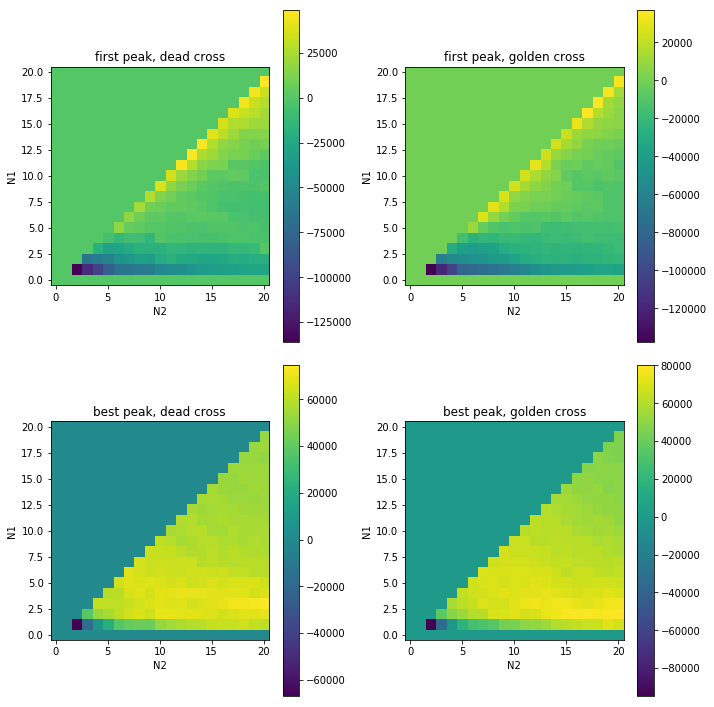

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(benefits_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, dead cross")
plt.colorbar()

plt.subplot(222)
plt.imshow(benefits_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, golden cross")
plt.colorbar()

plt.subplot(223)
plt.imshow(benefits_best_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, dead cross")
plt.colorbar()

plt.subplot(224)
plt.imshow(benefits_best_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, golden cross")
plt.colorbar()

plt.tight_layout()

### dead + golden のイメージプロット

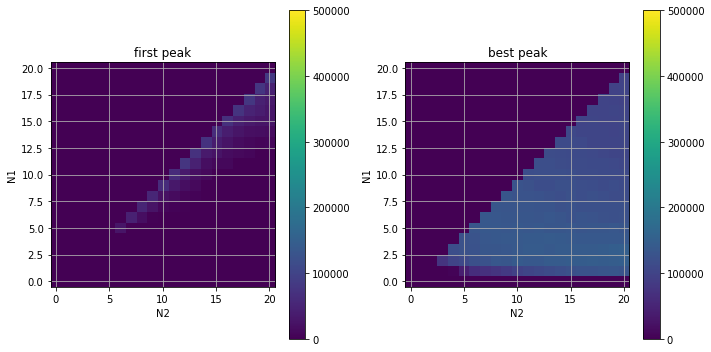

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(benefits_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("first peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 5e5)
plt.grid(True)

plt.subplot(122)
plt.imshow(benefits_best_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("best peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 5e5)
plt.grid(True)

plt.tight_layout()
plt.savefig("../images/analysis_of_ohlc(20190101-20190107)-2.png")

In [21]:
print(np.where(benefits_2d.sum(axis=2)==benefits_2d.sum(axis=2).max()), benefits_2d.sum(axis=2).max())
print(np.where(benefits_best_2d.sum(axis=2)==benefits_best_2d.sum(axis=2).max()), benefits_best_2d.sum(axis=2).max())

(array([19], dtype=int64), array([20], dtype=int64)) 82911
(array([3], dtype=int64), array([20], dtype=int64)) 151685


In [24]:
benefits_2d.sum(axis=2)[17, 18]

81425

### 結果の保存

In [23]:
res = dict(
    results_list=results_list, results_list_best=results_list_best,
    N_max=N_max, comb_list=comb_list, benefits_list=benefits_list,
    benefits_list_best=benefits_list_best, benefits_2d=benefits_2d,
    benefits_best_2d=benefits_best_2d, ary=ary
)

with open("../data/analysis_of_ohlc(20190101-20190107)-2_res.pickle", "wb") as ff:
    pickle.dump(res, ff)

### 平均値のプロット

In [ ]:
stat_dead = results["stat_dead"]
stat_golden = results["stat_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

### 箱ひげ図

In [ ]:
list_ext_dead = results["list_ext_dead"]
list_ext_golden = results["list_ext_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## OHLC等のプロット

In [33]:
target = [17, 18]
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    if comb_[0] == target[0] and comb_[1] == target[1]:
        results = results_list[ii]
        break
ema1 = results["ema1"]
ema2 = results["ema2"]
ema_diff = ema1 - ema2
cross_points = results["cross_points"]
benefits = results["benefits"]
a_k = results["a_k"]

In [34]:
for a, b in zip(a_k, benefits):
    print(a, b)

[29  1] -867
[44 -1] 53
[60  1] -2407
[64 -1] -870
[154   1] 238
[181  -1] -349
[204   1] 723
[232  -1] -525
[275   1] -440
[279  -1] -6619
[334   1] -458
[374  -1] 81
[378   1] -69
[385  -1] -495
[440   1] 2084
[510  -1] 110
[537   1] -93
[557  -1] 95
[572   1] 195
[604  -1] -1019
[682   1] -113
[683  -1] -412
[720   1] 572
[764  -1] -70
[778   1] 374
[806  -1] 153
[848   1] 500
[880  -1] 54
[894   1] -90
[895  -1] 11
[897   1] 137
[922  -1] 113
[930   1] -27
[938  -1] 141
[951   1] 586
[1000   -1] 121
[1004    1] 408
[1030   -1] 149
[1036    1] 715
[1074   -1] -428
[1152    1] 120
[1181   -1] 130
[1192    1] 121
[1242   -1] -782
[1279    1] -141
[1289   -1] 78
[1303    1] 346
[1329   -1] -58
[1348    1] 1088
[1380   -1] 1497
[1422    1] -198
[1432   -1] -1382
[1477    1] -94
[1480   -1] 215
[1481    1] -73
[1498   -1] -179
[1514    1] 48
[1563   -1] 44
[1574    1] -58
[1593   -1] -573
[1681    1] 281
[1820   -1] 219
[1837    1] -280
[1844   -1] -163
[1863    1] -340
[1864   -1] -494


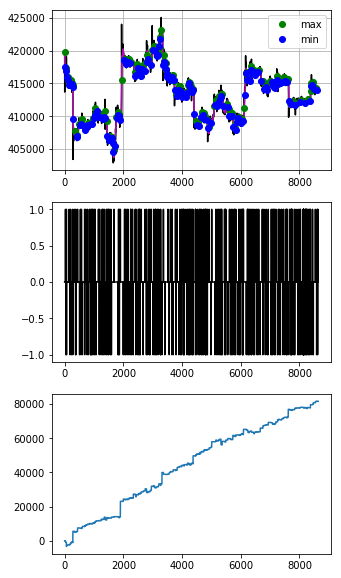

In [39]:
maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
close_ = df["close"].values
start = 0
end = len(ema1)

plt.figure(figsize=(5, 10))
plt.subplot(311)
plt.plot(close_[start:end], "k")
plt.plot(ema1[start:end], "g")
plt.plot(ema2[start:end], "m")

# index = (maxtab0[:, 0]>=start)&(maxtab0[:, 0]<end)
# plt.plot(maxtab0[index, 0], maxtab0[index, 1], "bo")
# index = (mintab0[:, 0]>=start)&(mintab0[:, 0]<end)
# plt.plot(mintab0[index, 0], mintab0[index, 1], "ro")

index = (maxtab_ema_diff[:, 0]>=start)&(maxtab_ema_diff[:, 0]<end)
plt.plot(maxtab_ema_diff[index, 0], ema1[maxtab_ema_diff[index, 0].astype(int)], "go", label="max")
index = (mintab_ema_diff[:, 0]>=start)&(mintab_ema_diff[:, 0]<end)
plt.plot(mintab_ema_diff[index, 0], ema1[mintab_ema_diff[index, 0].astype(int)], "bo", label="min")
plt.legend()
plt.grid(True)

plt.subplot(312)
plt.plot(cross_points[start:end], "k")
benefits_history = []
count = 0
for ii in range(len(ema1)):
    if ii == 0:
        benefits_history.append(0)
    elif count < len(a_k) and ii == a_k[count, 0]:
        benefits_history.append(benefits_history[-1] + benefits[count]*a_k[count, 1])
        count += 1
    else:
        benefits_history.append(benefits_history[-1])

plt.subplot(313)
plt.plot(benefits_history[start:end])